In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import surface, plotting
from nilearn import datasets
import os
from os.path import join as ospj
import pandas as pd 
from scipy.stats import spearmanr


### Age effect correspondence to S-A axis




In [3]:
depth="depth_3"

# load GAM results for dsistudio scalars and load SA axis
gam_age_dti_fa = pd.read_csv(f"/cbica/projects/luo_wm_dev/output/HCPD/superficialWM/GAM/dti_fa/GAMresults.dti_fa_{depth}.age_GMfiltered_noMW.csv")
gam_age_dti_fa = gam_age_dti_fa.drop(columns=gam_age_dti_fa.columns[0])

gam_age_md = pd.read_csv(f"/cbica/projects/luo_wm_dev/output/HCPD/superficialWM/GAM/md/GAMresults.md_{depth}.age_GMfiltered_noMW.csv")
gam_age_md = gam_age_md.drop(columns=gam_age_md.columns[0])

gam_age_ad = pd.read_csv(f"/cbica/projects/luo_wm_dev/output/HCPD/superficialWM/GAM/ad/GAMresults.ad_{depth}.age_GMfiltered_noMW.csv")
gam_age_ad = gam_age_ad.drop(columns=gam_age_ad.columns[0])

gam_age_rd = pd.read_csv(f"/cbica/projects/luo_wm_dev/output/HCPD/superficialWM/GAM/rd/GAMresults.rd_{depth}.age_GMfiltered_noMW.csv")
gam_age_rd = gam_age_rd.drop(columns=gam_age_rd.columns[0])

SAaxis = pd.read_csv("/cbica/projects/luo_wm_dev/SAaxis/SensorimotorAssociation_Axis.fsaverage5.csv")
SAaxis = SAaxis.rename(columns={"0": "SA_rank"})


In [4]:
# How many vertices have significant age effect after FDR?
dti_fa_significant_count = (gam_age_dti_fa['s_age.p.value.fdr'] < 0.05).sum()
md_significant_count = (gam_age_md['s_age.p.value.fdr'] < 0.05).sum()
ad_significant_count = (gam_age_ad['s_age.p.value.fdr'] < 0.05).sum()
rd_significant_count = (gam_age_rd['s_age.p.value.fdr'] < 0.05).sum()

total_vertices = 20484

print(f"dti_fa: {dti_fa_significant_count} vertices ({round(dti_fa_significant_count / total_vertices * 100, 2)}%) with significant age effect after FDR correction")
print(f"md: {md_significant_count} vertices ({round(md_significant_count / total_vertices * 100, 2)}%) with significant age effect after FDR correction")
print(f"ad: {ad_significant_count} vertices ({round(ad_significant_count / total_vertices * 100, 2)}%) with significant age effect after FDR correction")
print(f"rd: {rd_significant_count} vertices ({round(rd_significant_count / total_vertices * 100, 2)}%) with significant age effect after FDR correction")

dti_fa: 1229 vertices (6.0%) with significant age effect after FDR correction
md: 13255 vertices (64.71%) with significant age effect after FDR correction
ad: 9826 vertices (47.97%) with significant age effect after FDR correction
rd: 1648 vertices (8.05%) with significant age effect after FDR correction


In [5]:
# Remove vertices that hop gyri in dsistudio scalars and in fsaverage5 SAaxis
 
# Check for identical elements and count fully NaN vertices
dti_fa_nan_indices = np.where(np.isnan(gam_age_dti_fa['s_age.statistic']))[0]
md_nan_indices = np.where(np.isnan(gam_age_md['s_age.statistic']))[0]
print(f"{len(np.intersect1d(gam_age_dti_fa['element_id'][dti_fa_nan_indices], gam_age_md['element_id'][md_nan_indices]))} vertices were NaN across participants, including medial wall exclusion")  
nan_indices = dti_fa_nan_indices
 
# Filter SAaxis and gam_age dfs
SAaxis_filtered = SAaxis.drop(nan_indices)
gam_age_dti_fa_filtered = gam_age_dti_fa.drop(nan_indices)
gam_age_md_filtered = gam_age_md.drop(nan_indices)
gam_age_ad_filtered = gam_age_ad.drop(nan_indices)
gam_age_rd_filtered = gam_age_rd.drop(nan_indices)

# Print the length of gam_age_md_filtered and length of SAaxis_filtered
print(len(gam_age_md_filtered))
print(len(SAaxis_filtered))

2235 vertices were NaN across participants, including medial wall exclusion
18249
18249


In [6]:

# Reset index of SAaxis_filtered
SAaxis_filtered.reset_index(drop=True, inplace=True)

# Find indices of the medial wall in SAaxis_filtered
medial_wall_indices = np.where(SAaxis_filtered["SA_rank"] == 0)[0]

# Remove medial wall from SAaxis_filtered
SAaxis_filtered = SAaxis_filtered.drop(medial_wall_indices)
len(SAaxis_filtered)

# Remove corresponding rows from other DataFrames
gam_age_dti_fa_filtered.reset_index(drop=True, inplace=True)
gam_age_md_filtered.reset_index(drop=True, inplace=True)
gam_age_ad_filtered.reset_index(drop=True, inplace=True)
gam_age_rd_filtered.reset_index(drop=True, inplace=True)

gam_age_dti_fa_filtered = gam_age_dti_fa_filtered.drop(medial_wall_indices)
gam_age_md_filtered = gam_age_md_filtered.drop(medial_wall_indices)
gam_age_ad_filtered = gam_age_ad_filtered.drop(medial_wall_indices)
gam_age_rd_filtered = gam_age_rd_filtered.drop(medial_wall_indices)


In [7]:
# dti_fa
print("dti_fa")
partial_rsq_dti_fa, p_value_partial_dti_fa = spearmanr(gam_age_dti_fa_filtered['s_age.partial.rsq'], SAaxis_filtered)
delta_adj_rsq_dti_fa, p_value_delta_dti_fa = spearmanr(gam_age_dti_fa_filtered['s_age.delta.adj.rsq'], SAaxis_filtered)
print(f"partial_rsq: r = {partial_rsq_dti_fa}, p-value = {p_value_partial_dti_fa}")
print(f"delta_adj_rsq: r = {delta_adj_rsq_dti_fa}, p-value = {p_value_delta_dti_fa}")

# md
print("\nmd")
partial_rsq_md, p_value_partial_md = spearmanr(gam_age_md_filtered['s_age.partial.rsq'], SAaxis_filtered)
delta_adj_rsq_md, p_value_delta_md = spearmanr(gam_age_md_filtered['s_age.delta.adj.rsq'], SAaxis_filtered)
print(f"partial_rsq: r = {partial_rsq_md}, p-value = {p_value_partial_md}")
print(f"delta_adj_rsq: r = {delta_adj_rsq_md}, p-value = {p_value_delta_md}")

# ad
print("\nad")
partial_rsq_ad, p_value_partial_ad = spearmanr(gam_age_ad_filtered['s_age.partial.rsq'], SAaxis_filtered)
delta_adj_rsq_ad, p_value_delta_ad = spearmanr(gam_age_ad_filtered['s_age.delta.adj.rsq'], SAaxis_filtered)
print(f"partial_rsq: r = {partial_rsq_ad}, p-value = {p_value_partial_ad}")
print(f"delta_adj_rsq: r = {delta_adj_rsq_ad}, p-value = {p_value_delta_ad}")

# rd
print("\nrd")
partial_rsq_rd, p_value_partial_rd = spearmanr(gam_age_rd_filtered['s_age.partial.rsq'], SAaxis_filtered)
delta_adj_rsq_rd, p_value_delta_rd = spearmanr(gam_age_rd_filtered['s_age.delta.adj.rsq'], SAaxis_filtered)
print(f"partial_rsq: r = {partial_rsq_rd}, p-value = {p_value_partial_rd}")
print(f"delta_adj_rsq: r = {delta_adj_rsq_rd}, p-value = {p_value_delta_rd}")

dti_fa
partial_rsq: r = -0.12086292989772401, p-value = 2.3992233303508798e-60
delta_adj_rsq: r = -0.14486156472949033, p-value = 3.770453389852679e-86

md
partial_rsq: r = 0.1676501324564021, p-value = 3.84456816197097e-115
delta_adj_rsq: r = 0.16037924396302325, p-value = 2.0688080807283306e-105

ad
partial_rsq: r = 0.33501162100899984, p-value = 0.0
delta_adj_rsq: r = 0.3208812248432242, p-value = 0.0

rd
partial_rsq: r = 0.09236493726005959, p-value = 7.156727689044818e-36
delta_adj_rsq: r = 0.06406101896614082, p-value = 4.626035995487599e-18


Note: There are 6 vertices in the fsaverage5 S-A axis that have the same S-A rank assigned. Probably wouldn't have significantly impacted results but more reason to double check wb transform between fsLR and fsaverage5 
(see original Rmd)

Note: Preliminary correlation between S-A axis and age effects WITHOUT removing vertices are highly similar

In [9]:
# load GAM results without gyral hop filtering

gam_age_dti_fa_nonfiltered = pd.read_csv("/cbica/projects/luo_wm_dev/output/HCPD/superficialWM/GAM/GAMresults.dti_fa.age.csv")
gam_age_dti_fa_nonfiltered = gam_age_dti_fa_nonfiltered.drop(columns=gam_age_dti_fa_nonfiltered.columns[0])

gam_age_md_nonfiltered = pd.read_csv("/cbica/projects/luo_wm_dev/output/HCPD/superficialWM/GAM/GAMresults.md.age.csv")
gam_age_md_nonfiltered = gam_age_md_nonfiltered.drop(columns=gam_age_md_nonfiltered.columns[0])


SAaxis_nonfiltered = pd.read_csv("/cbica/projects/luo_wm_dev/SAaxis/SensorimotorAssociation_Axis.fsaverage5.csv")
SAaxis_nonfiltered = SAaxis_nonfiltered.rename(columns={"0": "SA_rank"})



In [10]:
# Reset index of SAaxis_filtered
SAaxis_nonfiltered.reset_index(drop=True, inplace=True)

# Find indices of the medial wall in SAaxis_filtered
medial_wall_indices_nonfiltered = np.where(SAaxis_nonfiltered["SA_rank"] == 0)[0]

# Remove medial wall from SAaxis_filtered
SAaxis_nonfiltered = SAaxis_nonfiltered.drop(medial_wall_indices_nonfiltered)
len(SAaxis_nonfiltered)


# Remove corresponding rows from scalars
gam_age_dti_fa_nonfiltered.reset_index(drop=True, inplace=True)
gam_age_md_nonfiltered.reset_index(drop=True, inplace=True)


gam_age_dti_fa_nonfiltered = gam_age_dti_fa_nonfiltered.drop(medial_wall_indices_nonfiltered)
gam_age_md_nonfiltered = gam_age_md_nonfiltered.drop(medial_wall_indices_nonfiltered)


# How many vertices have significant age effect after FDR?
dti_fa_significant_count_nonfiltered = (gam_age_dti_fa_nonfiltered['s_age.p.value.fdr'] < 0.05).sum()
md_significant_count_nonfiltered = (gam_age_md_nonfiltered['s_age.p.value.fdr'] < 0.05).sum()
 
total_vertices = 20484

print(f"dti_fa: {dti_fa_significant_count_nonfiltered} vertices ({round(dti_fa_significant_count_nonfiltered / total_vertices * 100, 2)}%) with significant age effect after FDR correction")
print(f"md: {md_significant_count_nonfiltered} vertices ({round(md_significant_count_nonfiltered / total_vertices * 100, 2)}%) with significant age effect after FDR correction")

dti_fa: 3142 vertices (15.34%) with significant age effect after FDR correction
md: 14546 vertices (71.01%) with significant age effect after FDR correction


In [152]:
# dti_fa
print("dti_fa")
partial_rsq_dti_fa, p_value_partial_dti_fa = spearmanr(gam_age_dti_fa_nonfiltered['s_age.partial.rsq'], SAaxis_nonfiltered)
delta_adj_rsq_dti_fa, p_value_delta_dti_fa = spearmanr(gam_age_dti_fa_nonfiltered['s_age.delta.adj.rsq'], SAaxis_nonfiltered)
print(f"partial_rsq: r = {partial_rsq_dti_fa}, p-value = {p_value_partial_dti_fa}")
print(f"delta_adj_rsq: r = {delta_adj_rsq_dti_fa}, p-value = {p_value_delta_dti_fa}")

# md
print("\nmd")
partial_rsq_md, p_value_partial_md = spearmanr(gam_age_md_nonfiltered['s_age.partial.rsq'], SAaxis_nonfiltered)
delta_adj_rsq_md, p_value_delta_md = spearmanr(gam_age_md_nonfiltered['s_age.delta.adj.rsq'], SAaxis_nonfiltered)
print(f"partial_rsq: r = {partial_rsq_md}, p-value = {p_value_partial_md}")
print(f"delta_adj_rsq: r = {delta_adj_rsq_md}, p-value = {p_value_delta_md}")

dti_fa
partial_rsq: r = -0.15762277938526173, p-value = 1.4034920812131995e-105
delta_adj_rsq: r = -0.15783042423435814, p-value = 7.4219501758999875e-106

md
partial_rsq: r = 0.16998127880393998, p-value = 1.0291009627274542e-122
delta_adj_rsq: r = 0.1701419826248892, p-value = 6.0349817450140613e-123


## Age effect maps

In [9]:
depth="depth_3"

# load GAM results for dsistudio scalars and load SA axis
gam_age_dti_fa = pd.read_csv(f"/cbica/projects/luo_wm_dev/output/HCPD/superficialWM/GAM/dti_fa/GAMresults.dti_fa_{depth}.age_GMfiltered_noMW.csv")
gam_age_dti_fa = gam_age_dti_fa.drop(columns=gam_age_dti_fa.columns[0])

gam_age_md = pd.read_csv(f"/cbica/projects/luo_wm_dev/output/HCPD/superficialWM/GAM/md/GAMresults.md_{depth}.age_GMfiltered_noMW.csv")
gam_age_md = gam_age_md.drop(columns=gam_age_md.columns[0])

gam_age_ad = pd.read_csv(f"/cbica/projects/luo_wm_dev/output/HCPD/superficialWM/GAM/ad/GAMresults.ad_{depth}.age_GMfiltered_noMW.csv")
gam_age_ad = gam_age_ad.drop(columns=gam_age_ad.columns[0])

gam_age_rd = pd.read_csv(f"/cbica/projects/luo_wm_dev/output/HCPD/superficialWM/GAM/rd/GAMresults.rd_{depth}.age_GMfiltered_noMW.csv")
gam_age_rd = gam_age_rd.drop(columns=gam_age_rd.columns[0])

SAaxis = pd.read_csv("/cbica/projects/luo_wm_dev/SAaxis/SensorimotorAssociation_Axis.fsaverage5.csv")
SAaxis = SAaxis.rename(columns={"0": "SA_rank"})


 # get lh and rh hemispheres and store as giftis

def store_gifti(df):
    df = df.astype(np.float32)
    df_gii_data = nib.gifti.gifti.GiftiDataArray(df)
    df_gii = nib.gifti.gifti.GiftiImage(darrays=[df_gii_data])
    return(df_gii)

# dti_fa
 
lh_gam_age_dti_fa = gam_age_dti_fa.iloc[0:10242]
lh_gam_age_dti_fa = lh_gam_age_dti_fa['s_age.partial.rsq']
rh_gam_age_dti_fa = gam_age_dti_fa.iloc[10242:20484]
rh_gam_age_dti_fa = rh_gam_age_dti_fa['s_age.partial.rsq']
lh_dti_fa_gii = store_gifti(lh_gam_age_dti_fa)
rh_dti_fa_gii = store_gifti(rh_gam_age_dti_fa)
 
# md
 
lh_gam_age_md = gam_age_md.iloc[0:10242]
lh_gam_age_md = lh_gam_age_md['s_age.partial.rsq']
rh_gam_age_md = gam_age_md.iloc[10242:20484]
rh_gam_age_md = rh_gam_age_md['s_age.partial.rsq']
lh_md_gii = store_gifti(lh_gam_age_md)
rh_md_gii = store_gifti(rh_gam_age_md)


# ad
 
lh_gam_age_ad = gam_age_ad.iloc[0:10242]
lh_gam_age_ad = lh_gam_age_ad['s_age.partial.rsq']
rh_gam_age_ad = gam_age_ad.iloc[10242:20484]
rh_gam_age_ad = rh_gam_age_ad['s_age.partial.rsq']
lh_ad_gii = store_gifti(lh_gam_age_ad)
rh_ad_gii = store_gifti(rh_gam_age_ad)



# rd
 
lh_gam_age_rd = gam_age_rd.iloc[0:10242]
lh_gam_age_rd = lh_gam_age_rd['s_age.partial.rsq']
rh_gam_age_rd = gam_age_rd.iloc[10242:20484]
rh_gam_age_rd = rh_gam_age_rd['s_age.partial.rsq']
lh_rd_gii = store_gifti(lh_gam_age_rd)
rh_rd_gii = store_gifti(rh_gam_age_rd)


# S-A axis
lh_SAaxis = SAaxis.iloc[0:10242]
lh_SAaxis = lh_SAaxis["SA_rank"]
rh_SAaxis = SAaxis.iloc[10242:20484]
rh_SAaxis = rh_SAaxis["SA_rank"]
lh_SAaxis_gii = store_gifti(lh_SAaxis)
rh_SAaxis_gii = store_gifti(rh_SAaxis)
 

#### fsaverage 5 S-A Axis 

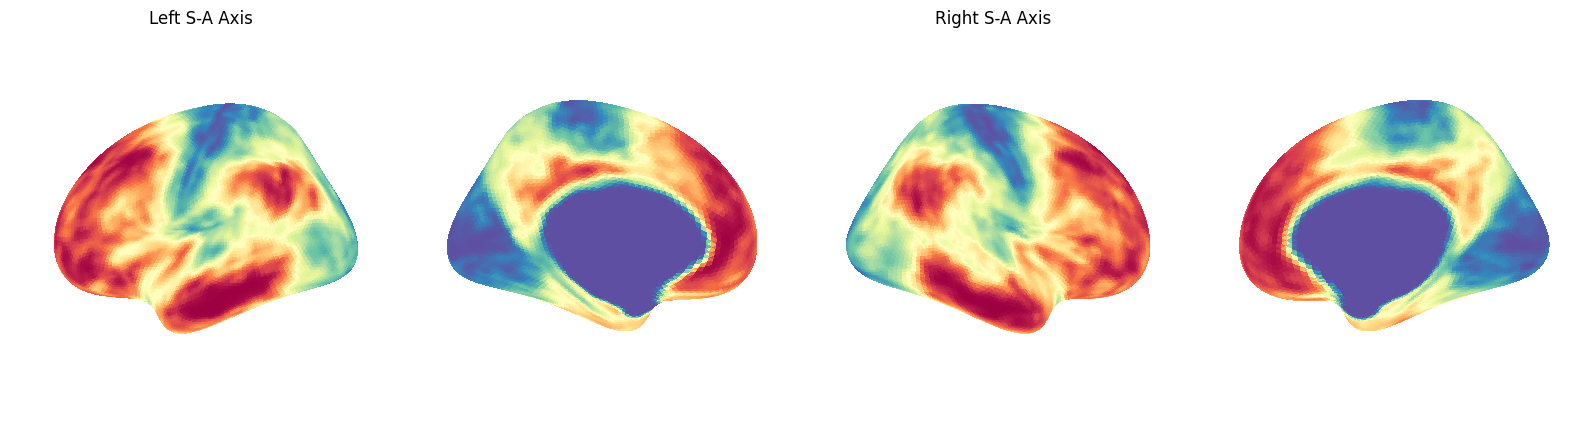

In [10]:
fsaverage = datasets.fetch_surf_fsaverage()

# Check S-A axis
fig, axes = plt.subplots(1, 4, figsize=(16, 8), subplot_kw={'projection': '3d'})

# Plot left hemisphere: lateral view
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_SAaxis_gii.darrays[0].data, bg_map=None, hemi='left', view='lateral', title="Left S-A Axis", axes=axes[0], cmap="Spectral_r")

# Plot left hemisphere: medial view
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_SAaxis_gii.darrays[0].data, bg_map=None, hemi='left', view='medial', axes=axes[1], cmap="Spectral_r")

# Plot right hemisphere: lateral view
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_SAaxis_gii.darrays[0].data, bg_map=None, hemi='right', view='lateral', title="Right S-A Axis", axes=axes[2], cmap="Spectral_r")

# Plot right hemisphere: medial view
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_SAaxis_gii.darrays[0].data, bg_map=None, hemi='right', view='medial', axes=axes[3], cmap="Spectral_r")
 
# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Age effect maps for FA and MD

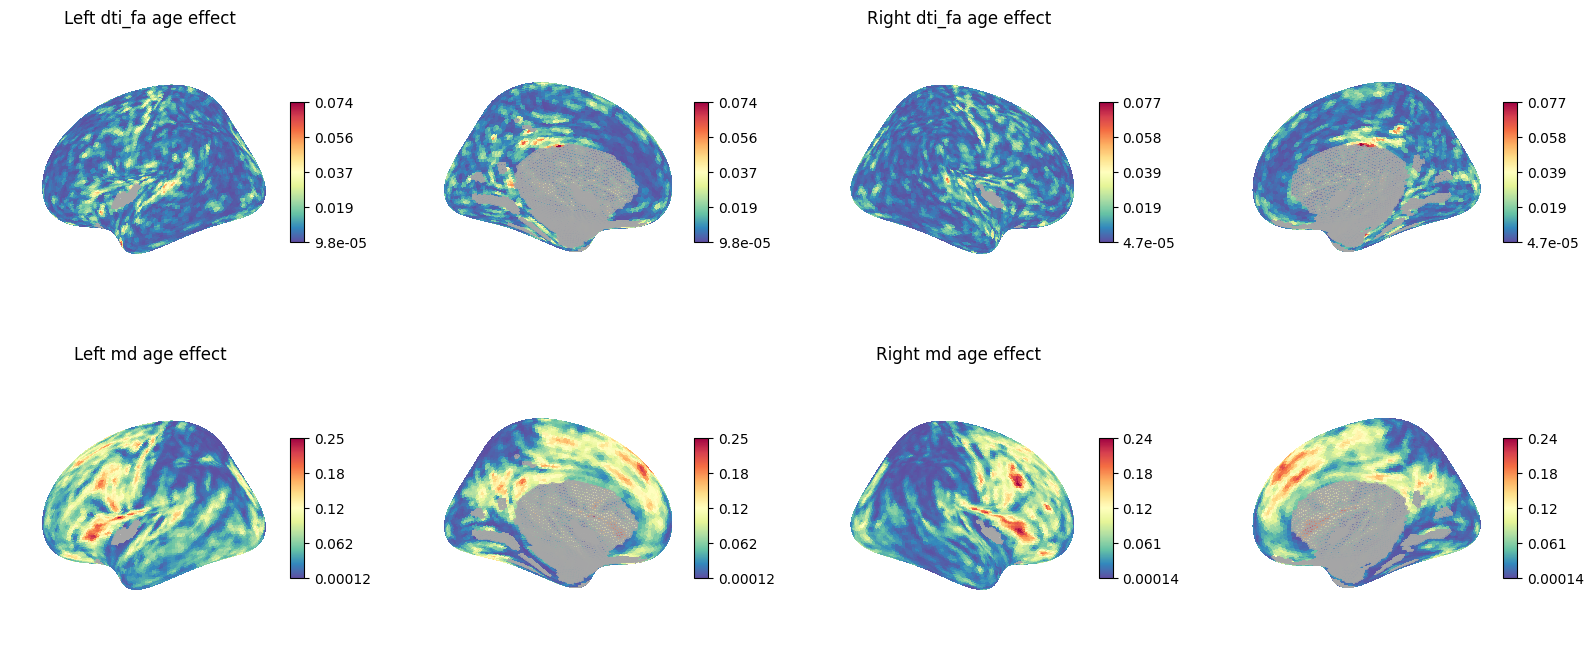

In [11]:
fsaverage = datasets.fetch_surf_fsaverage()

# Check S-A axis
fig, axes = plt.subplots(2, 4, figsize=(20, 8), subplot_kw={'projection': '3d'})

# dti_fa
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_dti_fa_gii.darrays[0].data, bg_map=None, hemi='left', view='lateral', title="Left dti_fa age effect", axes=axes[0, 0], cmap="Spectral_r", colorbar=True)

 
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_dti_fa_gii.darrays[0].data, bg_map=None, hemi='left', view='medial', axes=axes[0, 1], cmap="Spectral_r", colorbar=True)

 
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_dti_fa_gii.darrays[0].data, bg_map=None, hemi='right', view='lateral', title="Right dti_fa age effect", axes=axes[0, 2], cmap="Spectral_r", colorbar=True)

 
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_dti_fa_gii.darrays[0].data, bg_map=None, hemi='right', view='medial', axes=axes[0, 3], cmap="Spectral_r", colorbar=True)

# md
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_md_gii.darrays[0].data, bg_map=None, hemi='left', view='lateral', title="Left md age effect", axes=axes[1, 0], cmap="Spectral_r", colorbar=True)

 
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_md_gii.darrays[0].data, bg_map=None, hemi='left', view='medial', axes=axes[1, 1], cmap="Spectral_r", colorbar=True)

 
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_md_gii.darrays[0].data, bg_map=None, hemi='right', view='lateral', title="Right md age effect", axes=axes[1, 2], cmap="Spectral_r", colorbar=True)

 
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_md_gii.darrays[0].data, bg_map=None, hemi='right', view='medial', axes=axes[1, 3], cmap="Spectral_r", colorbar=True)

#plt.tight_layout()
plt.show()

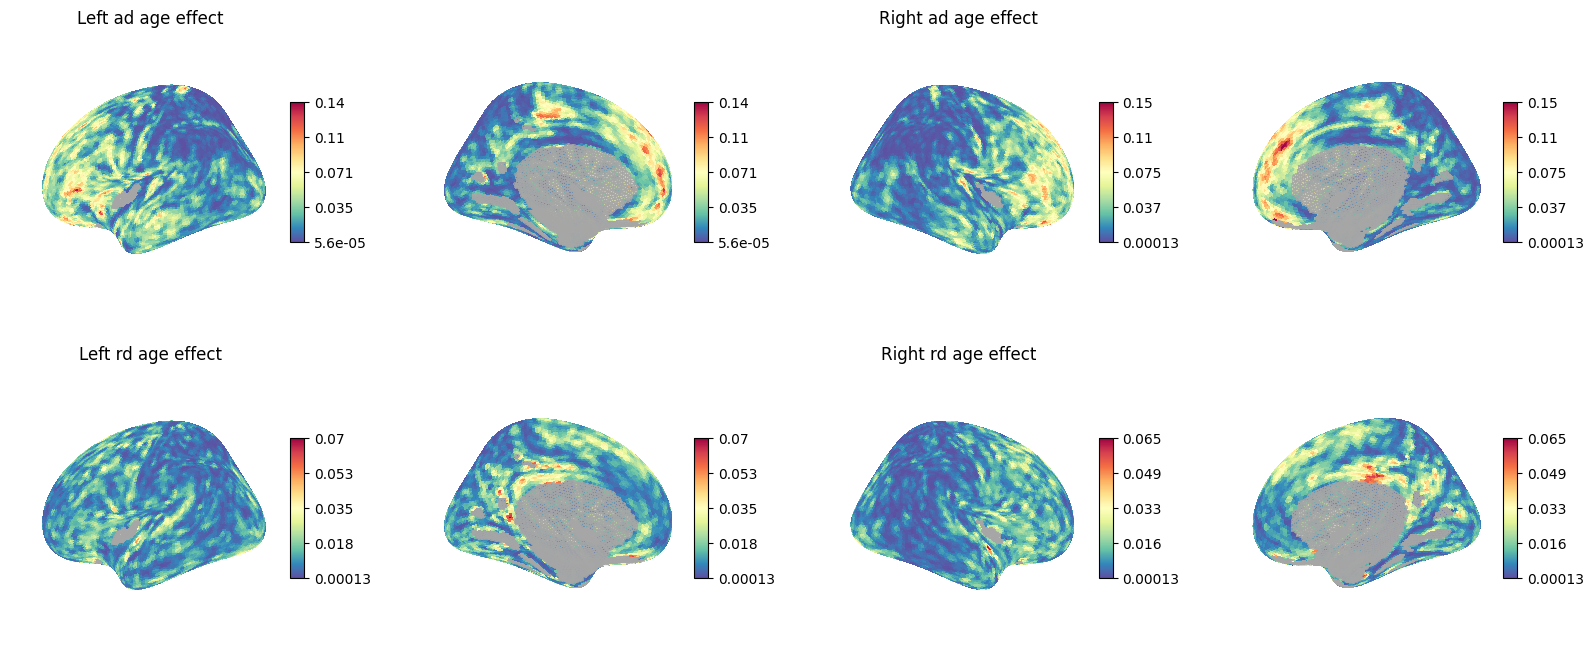

In [12]:
fsaverage = datasets.fetch_surf_fsaverage()

# Check S-A axis
fig, axes = plt.subplots(2, 4, figsize=(20, 8), subplot_kw={'projection': '3d'})

# ad
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_ad_gii.darrays[0].data, bg_map=None, hemi='left', view='lateral', title="Left ad age effect", axes=axes[0, 0], cmap="Spectral_r", colorbar=True)

 
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_ad_gii.darrays[0].data, bg_map=None, hemi='left', view='medial', axes=axes[0, 1], cmap="Spectral_r", colorbar=True)

 
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_ad_gii.darrays[0].data, bg_map=None, hemi='right', view='lateral', title="Right ad age effect", axes=axes[0, 2], cmap="Spectral_r", colorbar=True)

 
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_ad_gii.darrays[0].data, bg_map=None, hemi='right', view='medial', axes=axes[0, 3], cmap="Spectral_r", colorbar=True)

# rd
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_rd_gii.darrays[0].data, bg_map=None, hemi='left', view='lateral', title="Left rd age effect", axes=axes[1, 0], cmap="Spectral_r", colorbar=True)

 
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_rd_gii.darrays[0].data, bg_map=None, hemi='left', view='medial', axes=axes[1, 1], cmap="Spectral_r", colorbar=True)

 
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_rd_gii.darrays[0].data, bg_map=None, hemi='right', view='lateral', title="Right rd age effect", axes=axes[1, 2], cmap="Spectral_r", colorbar=True)

 
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_rd_gii.darrays[0].data, bg_map=None, hemi='right', view='medial', axes=axes[1, 3], cmap="Spectral_r", colorbar=True)

#plt.tight_layout()
plt.show()